# 利用ground truth,制作点特征的label

移动点云数据

读取每个GT，将GT转换成velo to velo

In [1]:
import numpy as np
import open3d as o3d
import os
import glob
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-03-09 21:14:00,608 - utils - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2024-03-09 21:14:00,608 - utils - NumExpr defaulting to 8 threads.


In [2]:
def read_calib_file(filepath):
    calib_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            key, value = line.split(':', 1)
            if key == 'R' or key == 'T':
                calib_data[key] = value.strip()

    return calib_data


def RT_matrix_maker(calib_data):
    if "R" in calib_data and "T" in calib_data:
        R_values = [float(x) for x in calib_data["R"].split()]
        T_values = [float(x) for x in calib_data["T"].split()]

        # 构造变换矩阵
        R_matrix = np.array(R_values).reshape(3, 3)
        T_vector = np.array(T_values).reshape(3, 1)
        RT_matrix = np.hstack((R_matrix, T_vector))
        RT_matrix = np.vstack((RT_matrix, [0, 0, 0, 1]))

        RT_matrix
    else:
        RT_matrix = None

    return RT_matrix

In [3]:
def get_gt_velo(gt_path, RT_matrix):
    RT_matrix_inv = np.linalg.inv(RT_matrix)
    with open(gt_path, 'r') as f:
        lines = f.readlines()
    transformed_lines = []
    for line in lines:
        pose = line.strip().split()  
        pose_matrix = np.eye(4)
        pose_matrix[:3, :] = np.array(pose).reshape(3, 4).astype(float)
        transformed_matrix = RT_matrix_inv @ pose_matrix @ RT_matrix
        transformed_pose = transformed_matrix[:3, :].flatten()
        transformed_lines.append(" ".join(map(str, transformed_pose)))
    gt_velo = transformed_lines

    data_matrices = []  # 用于存储所有的4x4矩阵
    for line in gt_velo:
        pose = line.strip().split()  # 切分每行数据
        data_matrix = np.eye(4)
        data_matrix[:3, :] = np.array(pose).reshape(3, 4).astype(float)
        data_matrices.append(data_matrix)

    data_matrices = np.array(data_matrices)
    return data_matrices


In [4]:
# 本函数的意义是将第[x]帧变换到[x-1]帧，输出变换结果
def get_pointcloud_trans(data_matrices, dataset, x):
    
    T = np.dot(np.linalg.inv(data_matrices[x-1]), data_matrices[x])
   
    
    #取第x帧和第y帧的点云
    data1 = np.fromfile(dataset[x], dtype=np.float32)
    data1 = data1.reshape((-1, 4))
    data1 = data1[:, :3]

    data2_pre = np.hstack((data1, np.ones((data1.shape[0], 1))))
    data2_pre = np.dot(T, data2_pre.T).T   
    data2 = data2_pre[:, :3] / data2_pre[:, 3].reshape((-1, 1))

    data_compare = np.fromfile(dataset[x-1], dtype=np.float32)
    data_compare = data_compare.reshape((-1, 4))
    data_compare = data_compare[:, :3]
    
    return data2, data_compare

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
def nearest_neighbor(src, dst):
    
    # assert src.shape == dst.shape
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [61]:
# 用来生成label的，测试时不要运行
data_list = ['00','01','02','04','05','06','07','09','10']
path = '../datasets/dataset/sequences/'

for idx in data_list:
    if idx in ['00', '01', '02']:
        path_calib = '../datasets/2011_10_03/calib_velo_to_cam.txt'
    else:
        path_calib = '../datasets/2011_09_30/calib_velo_to_cam.txt'
    path_data = os.path.join(path, idx)        
    velo_path = os.path.join(path_data, 'velodyne')
    gt_path = os.path.join(path_data, "{}.txt".format(idx))
    label_path = os.path.join(path_data, 'labels')
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    dataset = sorted(glob.glob(os.path.join(velo_path, '*.bin')))
    
    print(path_data)

    #测试用
    trans_data_path = os.path.join(path_data, 'trans_data')
    if not os.path.exists(trans_data_path):
        os.makedirs(trans_data_path)

    calib_data = read_calib_file(path_calib) 
    RT_matrix = RT_matrix_maker(calib_data)
    data_matrices = get_gt_velo(gt_path, RT_matrix)


    file0_name = "000000.label" #第0帧为空文件，因为无法向前映射
    empty_array = np.array([])
    empty_array.tofile(os.path.join(label_path, file0_name))
    np.savetxt(os.path.join(label_path, file0_name), empty_array)
    for i in range(1,len(dataset)):
        data_trans, data_compare = get_pointcloud_trans(data_matrices, dataset, i)
        data_trans = data_trans.astype(np.float32)
        # 保存变换结果，用于测试转换是否正确
        # data_trans.tofile(os.path.join(trans_data_path, '{:06d}.bin'.format(i)))

        #distance to score
        distances = nearest_neighbor(data_trans, data_compare)
        distances = np.array(distances)
        distances = distances[0, :]
        # print(distances)
        score = 1-1/(1+np.exp(-15*(distances-0.15)))
        score = score.astype(np.float32)
        
        score.tofile(os.path.join(label_path, '{:06d}.label'.format(i)))


../datasets/dataset/sequences/00
../datasets/dataset/sequences/01
../datasets/dataset/sequences/02
../datasets/dataset/sequences/04
../datasets/dataset/sequences/05
../datasets/dataset/sequences/06
../datasets/dataset/sequences/07
../datasets/dataset/sequences/09
../datasets/dataset/sequences/10


(124839, 3)
data2= (124823, 3)
score= (124839,)
[[4.94847218e-01 0.00000000e+00 5.05152782e-01]
 [6.65786780e-01 0.00000000e+00 3.34213220e-01]
 [7.52562657e-01 0.00000000e+00 2.47437343e-01]
 ...
 [2.78276344e-06 0.00000000e+00 9.99997217e-01]
 [2.46601604e-06 0.00000000e+00 9.99997534e-01]
 [1.86233997e-06 0.00000000e+00 9.99998138e-01]]
colors= (124839, 3)


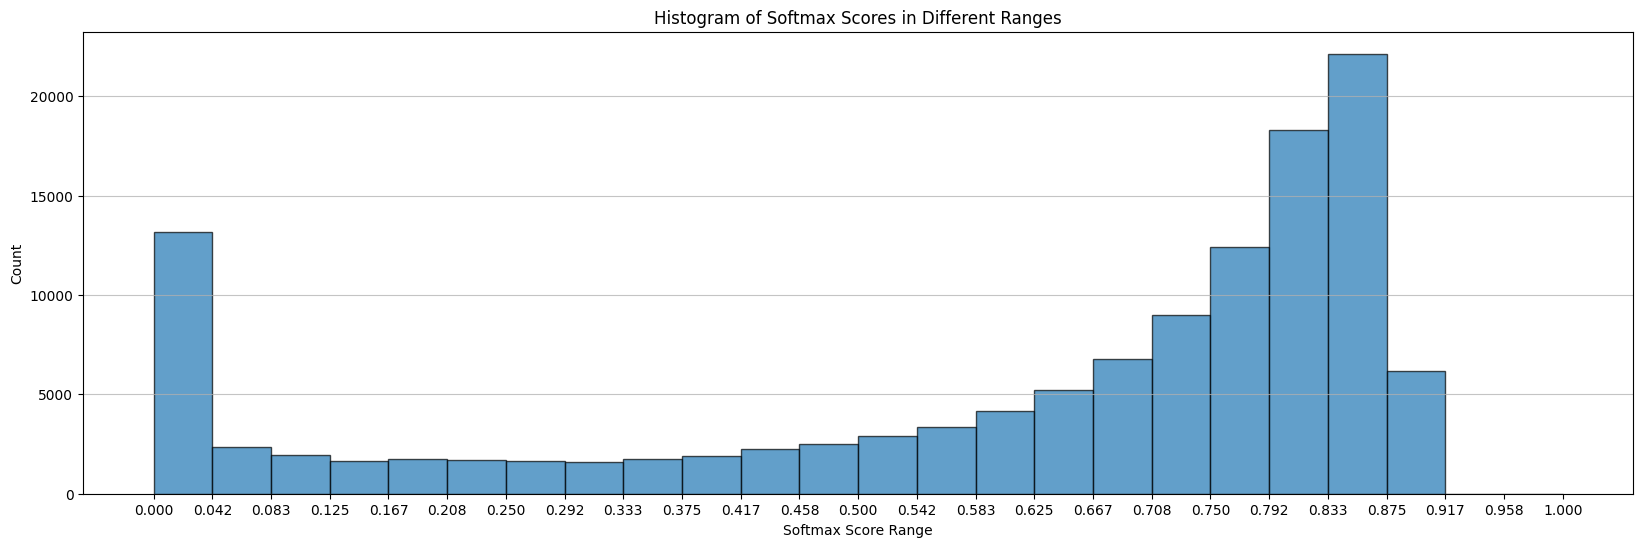

In [28]:
import numpy as np
import copy

def draw_registration_result(source, target):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    # source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

path1 = '../datasets/dataset/sequences/01/velodyne/000100.bin'
path2 = '../datasets/dataset/sequences/01/trans_data/000101.bin'
data1 = np.fromfile(path1, dtype=np.float32)
data2 = np.fromfile(path2, dtype=np.float32)
data1 = data1.reshape((-1, 4))
data1 = data1[:, :3]
data2 = data2.reshape((-1, 3))
print(data1.shape)
print("data2=", data2.shape)
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(data1)
point_cloud2 = o3d.geometry.PointCloud()
point_cloud2.points = o3d.utility.Vector3dVector(data2)
# draw_registration_result(point_cloud1, point_cloud2) #两帧点云的匹配效果


distances = nearest_neighbor(data1, data2)
distances = np.array(distances)
distances = distances[0, :]


score = 1-1/(1+np.exp(-15*(distances-0.15)))
print("score=", score.shape)
colors = np.c_[score, np.zeros_like(score), 1-score] 
colors_temp = np.c_[score, score, score]
print(colors)
print("colors=",colors.shape)
 
point_cloud1.colors = o3d.utility.Vector3dVector(colors)  # 设置点云颜色
o3d.visualization.draw_geometries([point_cloud1]) 

#滤除地面点点云
colors_filtered = colors.copy()
for i in range(len(data1)):
    if data1[i, 2] < -1.6:
        colors_filtered[i] = [1, 1, 1]
point_cloud1_filtered = o3d.geometry.PointCloud()
point_cloud1_filtered.points = o3d.utility.Vector3dVector(data1)
point_cloud1_filtered.colors = o3d.utility.Vector3dVector(colors_filtered)
o3d.visualization.draw_geometries([point_cloud1_filtered])

# 使用新的 bins 定义，因为 softmax_scores 的值在 0 到 1 之间
bins = np.linspace(0, 1, 25)

# 统计 softmax 分数的区间数量
hist_softmax, bin_edges_softmax = np.histogram(score, bins=bins)

# 绘制 softmax 分数的直方图
plt.figure(figsize=(20, 6))
plt.hist(score, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Softmax Score Range')
plt.ylabel('Count')
plt.title('Histogram of Softmax Scores in Different Ranges')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()



(374469,)
(499292,)
(124823, 3)
softmax_scores_shape= (124823,)
softmax_scores_dtype= float64


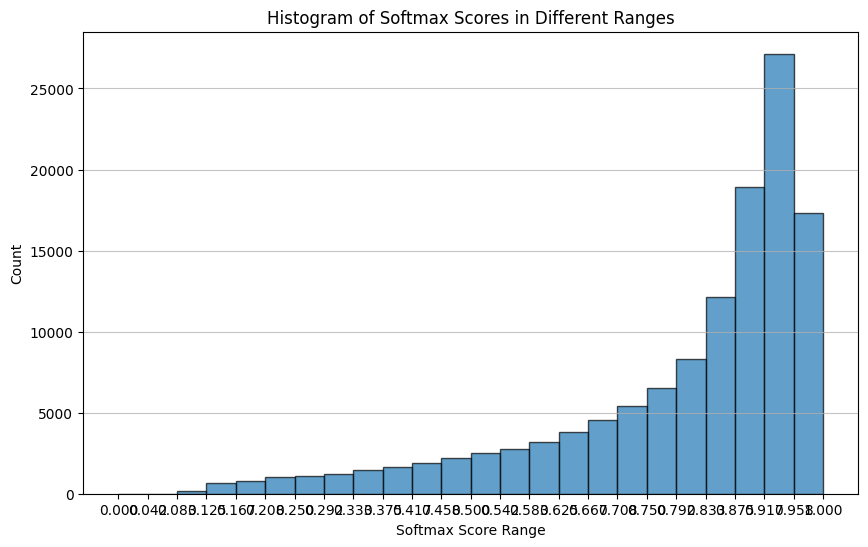

src= (124823, 3)


In [13]:
# 测试
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
source_path = '../datasets/dataset/sequences/01/labels/000101.label'
target_path = '../datasets/dataset/sequences/01/velodyne/000101.bin'
src = np.fromfile(source_path, dtype=np.float32)
print(src.shape)
# src = src.reshape((-1, 3))
# print(src.shape)
dst = np.fromfile(target_path, dtype=np.float32)
print(dst.shape)
dst = dst.reshape((-1, 4))
dst = dst[:, :3]
print(dst.shape)

# point_cloud1 = o3d.geometry.PointCloud()
# point_cloud2 = o3d.geometry.PointCloud()
# point_cloud1.points = o3d.utility.Vector3dVector(src)
# point_cloud2.points = o3d.utility.Vector3dVector(dst)

# point_cloud1.paint_uniform_color([1, 0.706, 0])
# point_cloud2.paint_uniform_color([0, 0.651, 0.929])
# o3d.visualization.draw_geometries([point_cloud1, point_cloud2],
#                                       zoom=0.4459,
#                                       front=[0.9288, -0.2951, -0.2242],
#                                       lookat=[1.6784, 2.0612, 1.4451],
#                                       up=[-0.3402, -0.9189, -0.1996])

distances = nearest_neighbor(src, dst)
distances = np.array(distances)
distances = distances[0, :]
softmax_scores = np.exp(-distances) 
print("softmax_scores_shape=",softmax_scores.shape)
print("softmax_scores_dtype=", softmax_scores.dtype)


# 使用新的 bins 定义，因为 softmax_scores 的值在 0 到 1 之间
bins_softmax = np.linspace(0, 1, 25)

# 统计 softmax 分数的区间数量
hist_softmax, bin_edges_softmax = np.histogram(softmax_scores, bins=bins_softmax)

# 绘制 softmax 分数的直方图
plt.figure(figsize=(10, 6))
plt.hist(softmax_scores, bins=bins_softmax, edgecolor='black', alpha=0.7)
plt.xlabel('Softmax Score Range')
plt.ylabel('Count')
plt.title('Histogram of Softmax Scores in Different Ranges')
plt.xticks(bins_softmax)
plt.grid(axis='y', alpha=0.75)
plt.show()


colors = np.c_[softmax_scores, np.zeros_like(softmax_scores), 1-softmax_scores]  # 将归一化的sequence距离转换为蓝绿色渐变颜色

# 创建点云对象
point_cloud_src = o3d.geometry.PointCloud()
point_cloud_src.points = o3d.utility.Vector3dVector(src)
point_cloud_src.colors = o3d.utility.Vector3dVector(colors)  # 设置点云颜色

print("src=",src.shape)
# print("colors=",colors.shape)

# 可视化
o3d.visualization.draw_geometries([point_cloud_src])

point_cloud1 = o3d.geometry.PointCloud()
point_cloud2 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(src)
point_cloud2.points = o3d.utility.Vector3dVector(dst)
point_cloud1.paint_uniform_color([1, 0.706, 0])
point_cloud2.paint_uniform_color([0, 0.651, 0.929])
o3d.visualization.draw_geometries([point_cloud1, point_cloud2],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
import glob


def nearest_neighbor(src, dst):
    
    # assert src.shape == dst.shape
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

data_list = ['00','01','02','04','05','06','07','09','10']
path = '../datasets/sequences/'

for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    label_path = os.path.join(path_data, 'labels')
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    pre_label_path = os.path.join(path_data, 'pre_labels')
    
    dataset = sorted(glob.glob(os.path.join(velo_path, '*.bin')))
    labelset = sorted(glob.glob(os.path.join(pre_label_path, '*.label')))
    
    print(label_path)

    for i in range(1,len(dataset)):
        src = np.fromfile(labelset[i], dtype=np.float32)
        dst = np.fromfile(dataset[i-1], dtype=np.float32)
        src = src.reshape((-1, 4))
        dst = dst.reshape((-1, 4))
        src = src[:, :3]
        dst = dst[:, :3]
        distances = nearest_neighbor(src, dst)
        distances = np.array(distances)
        distances = distances[0, :]
        
        # print("distances.shape=", distances.shape)
        # print(distances[:10])
       
        softmax_scores = np.exp(-distances) 
        softmax_scores = softmax_scores.astype(np.float32)
        # print("point.shape=", src.shape)
        # print("softmax_scores=", softmax_scores.shape)
        
        softmax_scores.tofile(os.path.join(label_path, '{:06d}.label'.format(i)))

    
        


../datasets/sequences/00/labels
../datasets/sequences/01/labels
../datasets/sequences/02/labels
../datasets/sequences/04/labels
../datasets/sequences/05/labels
../datasets/sequences/06/labels
../datasets/sequences/07/labels
../datasets/sequences/09/labels
../datasets/sequences/10/labels
